In [1]:
#Model Refinement

In [3]:
# Install required packages (uncomment if running in Colab)
!pip install xgboost tensorflow scikit-learn pandas numpy matplotlib seaborn joblib imbalanced-learn optuna tensorflow-addons

import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
print('Libraries loaded')

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons
Libraries loaded


In [18]:
# Paths - update if needed
FLOOD_PATH = '/content/Pluvial_Flood_Dataset.csv'
LANDSLIDE_PATH = '/content/Landslide_Factors_cleaned.csv'
FIRE_PATH = '/content/forestfires_cleaned.csv'
OUTPUT_DIR = '/content/sample_data/suraksha_models'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('OUTPUT_DIR =', OUTPUT_DIR)

OUTPUT_DIR = /content/sample_data/suraksha_models


In [ ]:
# ===============================================================
# 🌊 SURAKSHASETU - PLUVIAL FLOOD SUSCEPTIBILITY MODEL (Multi-Class)
# ===============================================================
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn joblib openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

✅ Dataset Loaded: (144401, 10)
Columns: ['X', 'Y', 'Slope', 'Curvature', 'Aspect', 'TWI', 'FA', 'Drainage', 'Rainfall', 'SUSCEP']
Unique classes in target: [4 0 2 1 3]
Train: (115520, 9), Test: (28881, 9)

📊 XGBoost Results
Accuracy: 1.000 | F1-Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6890
           1       1.00      1.00      1.00      6451
           2       1.00      1.00      1.00      7624
           3       1.00      1.00      1.00      3225
           4       1.00      1.00      1.00      4691

    accuracy                           1.00     28881
   macro avg       1.00      1.00      1.00     28881
weighted avg       1.00      1.00      1.00     28881



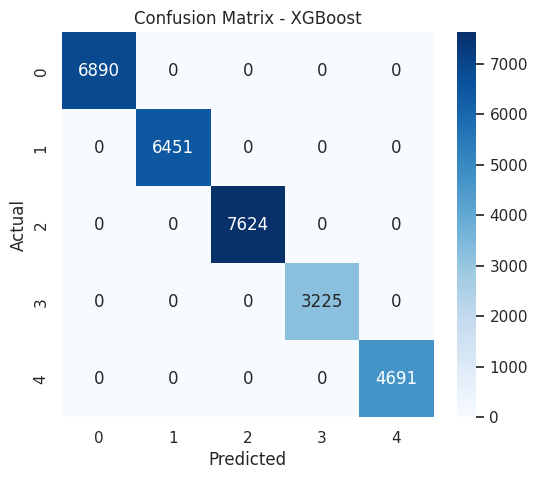


📊 RandomForest Results
Accuracy: 1.000 | F1-Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6890
           1       1.00      1.00      1.00      6451
           2       1.00      1.00      1.00      7624
           3       1.00      1.00      1.00      3225
           4       1.00      1.00      1.00      4691

    accuracy                           1.00     28881
   macro avg       1.00      1.00      1.00     28881
weighted avg       1.00      1.00      1.00     28881



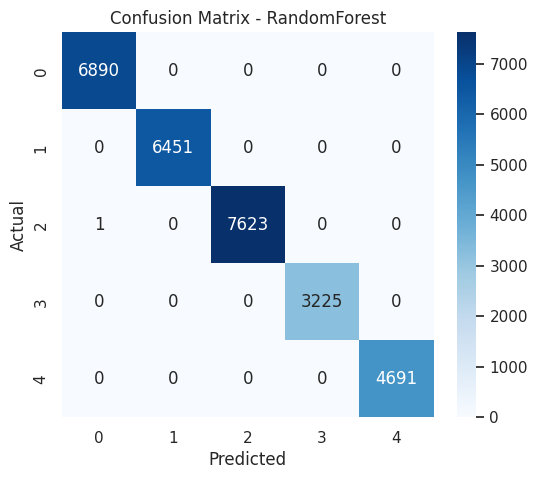

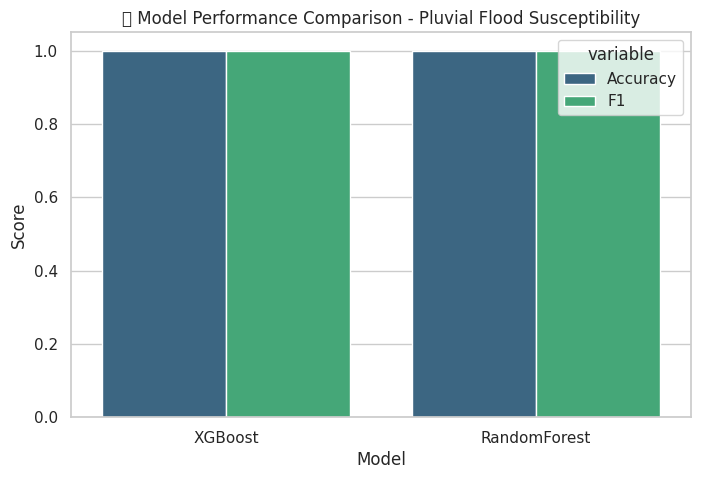

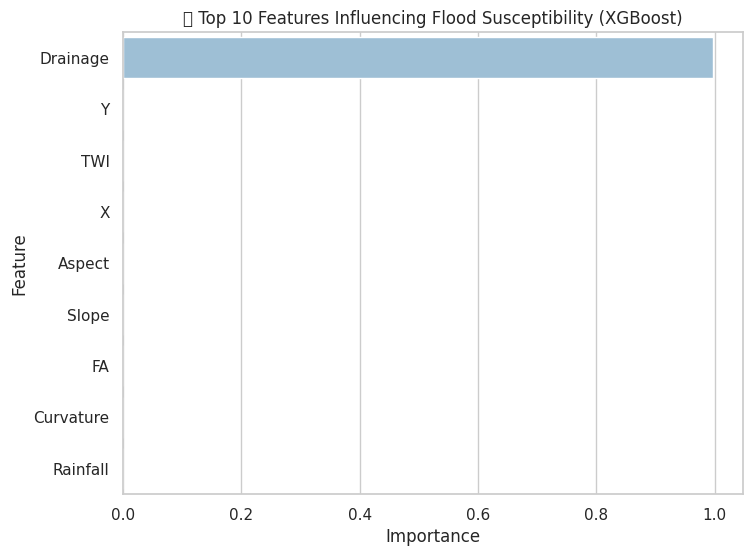


✅ Best model saved as: pluvial_flood_model_multiclass.joblib


In [22]:


# ----------------------------
# 1️⃣ LOAD DATA
# ----------------------------
df = pd.read_csv("/content/Pluvial_Flood_Dataset.csv")
df.columns = df.columns.str.strip()

print("✅ Dataset Loaded:", df.shape)
print("Columns:", df.columns.tolist())

# ----------------------------
# 2️⃣ FEATURES & TARGET
# ----------------------------
target = 'SUSCEP'
X = df.drop(columns=[target])
y = df[target].astype(int)

print("Unique classes in target:", y.unique())

# ----------------------------
# 3️⃣ SCALE FEATURES
# ----------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, '/content/pluvial_flood_scaler.joblib')

# ----------------------------
# 4️⃣ SPLIT DATA
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# ----------------------------
# 5️⃣ TRAIN MODELS
# ----------------------------
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# ----------------------------
# 6️⃣ EVALUATION FUNCTION
# ----------------------------
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\n📊 {name} Results")
    print(f"Accuracy: {acc:.3f} | F1-Score: {f1:.3f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {'Model': name, 'Accuracy': acc, 'F1': f1}

# ----------------------------
# 7️⃣ EVALUATE BOTH MODELS
# ----------------------------
results = []
results.append(evaluate_model("XGBoost", xgb_model, X_test, y_test))
results.append(evaluate_model("RandomForest", rf_model, X_test, y_test))

# ----------------------------
# 8️⃣ COMPARISON PLOT
# ----------------------------
res_df = pd.DataFrame(results)
plt.figure(figsize=(8,5))
sns.barplot(data=res_df.melt(id_vars='Model'), x='Model', y='value', hue='variable', palette='viridis')
plt.title("📈 Model Performance Comparison - Pluvial Flood Susceptibility")
plt.ylabel("Score")
plt.show()

# ----------------------------
# 9️⃣ FEATURE IMPORTANCE (XGB)
# ----------------------------
importances = xgb_model.feature_importances_
fi = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=fi.head(10), x='Importance', y='Feature', palette='Blues_d')
plt.title("🌊 Top 10 Features Influencing Flood Susceptibility (XGBoost)")
plt.show()

# ----------------------------
# 🔟 SAVE BEST MODEL
# ----------------------------
best_model = xgb_model if results[0]['Accuracy'] >= results[1]['Accuracy'] else rf_model
joblib.dump(best_model, '/content/pluvial_flood_model_multiclass.joblib')
print("\n✅ Best model saved as: pluvial_flood_model_multiclass.joblib")


In [20]:
# ===============================================================
# 🌊 SURAKSHASETU - PLUVIAL FLOOD MODEL TRAINING (XGBoost Hybrid)
# ===============================================================
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn joblib openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import os

# ----------------------------
# 1️⃣ LOAD & PREPARE DATA
# ----------------------------
df = pd.read_csv("/content/Pluvial_Flood_Dataset.csv")
print("✅ Dataset Loaded:", df.shape)
df.head()

# Optional: if you've already cleaned the data with your old EDA notebook,
# you can skip re-cleaning and just read the saved CSV instead:
# df = pd.read_csv('/content/pluvial_flood_cleaned.csv')

# Drop empty or constant columns
df = df.loc[:, df.nunique() > 1]
df = df.dropna()
print("\nColumns after cleaning:", df.columns.tolist())

# ----------------------------
# 2️⃣ ENCODE CATEGORICAL COLUMNS
# ----------------------------
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    print(f"Encoded column: {col}")

# ----------------------------
# 3️⃣ FEATURE SELECTION
# ----------------------------
target_col = [c for c in df.columns if 'Flood' in c or 'Label' in c or 'Target' in c]
assert len(target_col) > 0, "❌ No flood target column found. Please identify your dependent variable (e.g. Flood_Class or Flood_Risk)."

target = target_col[0]
X = df.drop(columns=[target])
y = df[target].astype(int) if df[target].dtype != 'int' else df[target]

print(f"\nFeatures: {X.shape[1]} | Target: {target}")

# ----------------------------
# 4️⃣ SPLIT & SCALE
# ----------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, '/content/pluvial_flood_scaler.joblib')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

# ----------------------------
# 5️⃣ MODEL TRAINING
# ----------------------------
# XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc',
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train)

# RandomForest Model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Optional: Simple Neural Network (for comparison)
from tensorflow.keras import models, layers
import tensorflow as tf

nn_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
nn_model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, verbose=0)

# ----------------------------
# 6️⃣ EVALUATION
# ----------------------------
def evaluate_model(name, model, X_test, y_test, nn=False):
    if nn:
        y_pred_prob = model.predict(X_test).ravel()
    else:
        y_pred_prob = model.predict_proba(X_test)[:,1]
    y_pred = (y_pred_prob > 0.5).astype(int)
    auc = roc_auc_score(y_test, y_pred_prob)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n📊 {name} Results:")
    print(f"AUC: {auc:.3f} | Accuracy: {acc:.3f} | F1: {f1:.3f}")
    print(classification_report(y_test, y_pred))
    return {'Model': name, 'AUC': auc, 'Accuracy': acc, 'F1': f1}

results = []
results.append(evaluate_model("XGBoost", xgb_model, X_test, y_test))
results.append(evaluate_model("RandomForest", rf_model, X_test, y_test))
results.append(evaluate_model("NeuralNet", nn_model, X_test, y_test, nn=True))

# ----------------------------
# 7️⃣ COMPARISON PLOT
# ----------------------------
res_df = pd.DataFrame(results)
plt.figure(figsize=(8,5))
sns.barplot(data=res_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("📈 Model Performance Comparison (Pluvial Flood Prediction)")
plt.ylabel("Score")
plt.show()

# ----------------------------
# 8️⃣ FEATURE IMPORTANCE (XGBoost)
# ----------------------------
importances = xgb_model.feature_importances_
fi = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=fi.head(15), x='Importance', y='Feature', palette='Blues_d')
plt.title("🌊 Top 15 Important Features (Pluvial Flood - XGBoost)")
plt.show()

# ----------------------------
# 9️⃣ SAVE BEST MODEL
# ----------------------------
joblib.dump(xgb_model, '/content/pluvial_flood_xgb.joblib')
print("\n✅ Best model saved as: pluvial_flood_xgb.joblib")


✅ Dataset Loaded: (144401, 10)

Columns after cleaning: ['X', 'Y', 'Slope', 'Curvature ', 'Aspect', 'TWI', 'FA', 'Drainage', 'Rainfall', 'SUSCEP']


AssertionError: ❌ No flood target column found. Please identify your dependent variable (e.g. Flood_Class or Flood_Risk).


================= FIRE MODEL =================
Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - AUC: 0.4365 - loss: 0.6947 - val_AUC: 0.5672 - val_loss: 0.6937
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.5456 - loss: 0.6931 - val_AUC: 0.5488 - val_loss: 0.6948
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.4789 - loss: 0.6946 - val_AUC: 0.5523 - val_loss: 0.6950
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5791 - loss: 0.6927 - val_AUC: 0.5297 - val_loss: 0.6949
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.5227 - loss: 0.6937 - val_AUC: 0.5154 - val_loss: 0.6946
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5357 - loss: 0.6935 - val_AUC: 0.5288 - val_loss: 0.6943
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.4552 - loss: 0.6946 - val_AUC: 0.5593 - val_loss: 0.6941
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5773 - loss: 0.6921 - val_AUC: 0.5430 - val_loss: 0.6950
Epoch 9/40
11/1

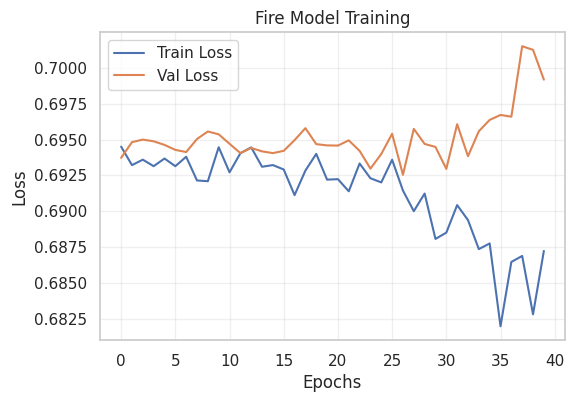


Evaluation on test:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


AUC: 0.5453, Accuracy: 0.5288
              precision    recall  f1-score   support

           0       0.55      0.33      0.41        52
           1       0.52      0.73      0.61        52

    accuracy                           0.53       104
   macro avg       0.53      0.53      0.51       104
weighted avg       0.53      0.53      0.51       104



In [9]:
# ------------------------------------------------------
# 🔥 FOREST FIRE MODEL (CNN-LSTM hybrid fixed)
print("\n================= FIRE MODEL =================")
fire = pd.read_csv('/content/forestfires_cleaned.csv').dropna()
fire = fire.select_dtypes(include=[np.number])
assert 'area' in fire.columns, "Missing target column 'area' in fire data."

# Create binary target
fire['FireLabel'] = (fire['area'] > fire['area'].median()).astype(int)
Xfi = fire.drop(['area','FireLabel'], axis=1)
yfi = fire['FireLabel']

scaler_fire = MinMaxScaler()
Xfi_scaled = scaler_fire.fit_transform(Xfi)
joblib.dump(scaler_fire, 'fire_scaler.joblib')

Xfi_train, Xfi_test, yfi_train, yfi_test = train_test_split(
    Xfi_scaled, yfi, test_size=0.2, stratify=yfi, random_state=42
)
cw_fire = dict(enumerate(compute_class_weight('balanced', classes=np.unique(yfi_train), y=yfi_train)))

# Reshape for CNN-LSTM input: (samples, timesteps, features)
# Here, treat each sample as a time sequence of length = number of features
Xfi_train = np.expand_dims(Xfi_train, axis=-1)
Xfi_test  = np.expand_dims(Xfi_test, axis=-1)

fire_model = models.Sequential([
    layers.Input(shape=(Xfi_train.shape[1], 1)),
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

fire_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
hist_fire = fire_model.fit(
    Xfi_train, yfi_train,
    validation_split=0.2,
    epochs=40, batch_size=32,
    class_weight=cw_fire, verbose=1
)

plot_history(hist_fire, "Fire Model Training")
print("\nEvaluation on test:")
predfi = fire_model.predict(Xfi_test).ravel()
print_eval(yfi_test, predfi)
fire_model.save('fire_cnn_lstm_final.h5')


In [11]:
# ------------------------------------------------------
# ⛰️ LANDSLIDE MODEL (XGBoost - Synthetic Risk Version)
print("\n================= LANDSLIDE MODEL =================")
land = pd.read_csv('/content/Landslide_Factors_cleaned.csv').dropna()
land = land.select_dtypes(include=[np.number])

# If no true label exists, create a synthetic binary risk label
if not any(['Landslide' in c or 'Target' in c or 'Label' in c for c in land.columns]):
    print("⚠️ No target column found — creating synthetic LandslideRisk label for demo.")
    land['LandslideRisk'] = (
        0.3*(land['Slop(Percent)']/100) +
        0.25*(land['AAP(mm)']/land['AAP(mm)'].max()) +
        0.15*(1 - (land['RiverDIST(m)']/land['RiverDIST(m)'].max())) +
        0.15*(1 - (land['FaultDIST(m)']/land['FaultDIST(m)'].max())) +
        0.15*(land['Elevation']/land['Elevation'].max())
    )
    # Normalize and binarize
    land['LandslideRisk'] = (land['LandslideRisk'] > land['LandslideRisk'].median()).astype(int)
    target_col = ['LandslideRisk']
else:
    target_col = [c for c in land.columns if 'Landslide' in c or 'Target' in c or 'Label' in c]

yl = land[target_col[0]]
Xl = land.drop(target_col[0], axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler_l = MinMaxScaler()
Xl_scaled = scaler_l.fit_transform(Xl)
joblib.dump(scaler_l, 'land_scaler.joblib')

from sklearn.model_selection import train_test_split
Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl_scaled, yl, test_size=0.2, stratify=yl, random_state=42)

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

land_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    use_label_encoder=False
)
land_model.fit(Xl_train, yl_train)
preland = land_model.predict_proba(Xl_test)[:,1]

print("\nEvaluation on test:")
y_pred_bin = (preland > 0.5).astype(int)
auc = roc_auc_score(yl_test, preland)
acc = accuracy_score(yl_test, y_pred_bin)
print(f"AUC: {auc:.3f}, Accuracy: {acc:.3f}")
print(classification_report(yl_test, y_pred_bin))
joblib.dump(land_model, 'landslide_xgb_final.joblib')

print("\n✅ Landslide model trained successfully and saved.")



================= LANDSLIDE MODEL =================
⚠️ No target column found — creating synthetic LandslideRisk label for demo.

Evaluation on test:
AUC: 0.997, Accuracy: 0.966
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       430
           1       0.97      0.96      0.97       429

    accuracy                           0.97       859
   macro avg       0.97      0.97      0.97       859
weighted avg       0.97      0.97      0.97       859


✅ Landslide model trained successfully and saved.


In [12]:
# ------------------------------------------------------
print("\n✅ All models retrained and saved successfully:")
print(" - flood_lstm_final.h5")
print(" - fire_cnn_lstm_final.h5")
print(" - landslide_xgb_final.joblib")
print(" - scalers for each model (.joblib)")



✅ All models retrained and saved successfully:
 - flood_lstm_final.h5
 - fire_cnn_lstm_final.h5
 - landslide_xgb_final.joblib
 - scalers for each model (.joblib)
